In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import fu, nu
from pandas import DataFrame, Index, Series, concat, notnull, to_datetime
import json
import numpy as np
import os
import os.path as osp
import pandas as pd
import re

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(metrics_evaluation_open_world_df='', first_responder_master_registry_file_stats_df='')
logs_df = data_frames_dict['metrics_evaluation_open_world_df']
print(logs_df.shape) # (171766, 111)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/first_responder_master_registry_file_stats_df.pkl.
(171766, 126)



# File Stats Created for Metrics Evaluation Open World

In [4]:

# Get all the Open World file stats into one data frame
metrics_evaluation_open_world_file_stats_df = DataFrame([])
logs_path = '../data/logs/Metrics Evaluation Open World'

# Get all the directory names which are suffixed by the participant ID
directories_list = os.listdir(logs_path)

# Loop through the directories and IDs and find a pair that matches
for dir_name in directories_list:
    for participant_id in range(2_024_201, 2_024_223+1):
        if dir_name.endswith(str(participant_id)):
            
            # Add the JSONs to the data frame
            folder_path = osp.join(logs_path, dir_name)
            
            # Iterate over the files in the current subdirectory
            for file_name in os.listdir(folder_path):
                
                # If the file is a JSON file
                if file_name.endswith('.json'):

                    # Create a data frame from the flattened dictionary
                    json_path = osp.join(folder_path, file_name)
                    with open(json_path, 'r') as f: file_json = json.load(f)
                    row_dict = {
                        'participant_id': participant_id,
                        'sub_directory': folder_path.split('/')[-1],
                        'json_file_name': file_name
                    }
                    flattened_json_dict = nu.get_row_dictionary(file_json, row_dict=row_dict, key_prefix='')
                    flattened_json_dict['session_uuid'] = flattened_json_dict.pop('sessionId')
                    file_stats_df = DataFrame(flattened_json_dict, index=Index([0]))
                    
                    # Append the data frame for the current subdirectory to the main data frame and break the participant ID loop
                    metrics_evaluation_open_world_file_stats_df = pd.concat([metrics_evaluation_open_world_file_stats_df, file_stats_df], axis='index')
            break

metrics_evaluation_open_world_file_stats_df = metrics_evaluation_open_world_file_stats_df.reset_index(drop=True)
nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
print(metrics_evaluation_open_world_file_stats_df.participant_id.nunique()) # 22
print(metrics_evaluation_open_world_file_stats_df.shape) # (43, 3525)

Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_file_stats_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_file_stats_df.csv
22
(43, 3525)


In [5]:

metrics_evaluation_open_world_file_stats_df = nu.load_object('metrics_evaluation_open_world_file_stats_df')

# Get the columns that consistently have only one value in them per session
single_value_cols_set = set(logs_df.columns)
for session_uuid, session_df in logs_df.groupby('session_uuid'):
    single_value_cols = set([col for col in session_df.columns if session_df[col].nunique() == 1])
    single_value_cols_set = single_value_cols_set.intersection(single_value_cols)
# print(single_value_cols_set)
rows_list = []
for session_uuid, session_df in logs_df[single_value_cols_set].dropna(axis='columns', how='all').groupby('session_uuid'):
    row_dict = {cn: session_df[cn].dropna().max() for cn in session_df.columns}
    rows_list.append(row_dict)
left_df = DataFrame(rows_list)
# print(left_df.shape)

# Get the learner types from the spreadsheet
if nu.pickle_exists('disaster_day_itm_405_learner_types_df'): right_df = nu.load_object('disaster_day_itm_405_learner_types_df')
else:
    file_path = '../data/xlsx/disaster_day_itm_405_3.6.2024.xlsx'
    right_df = read_excel(file_path)
    right_df.columns = [
        'session_file_date', 'csv_file_name', 'session_uuid', 'responder_name', 'responder_type', 'site_name', 'encounter_layout'
    ]
    right_df = right_df.dropna(axis='columns', how='all')
    if 'session_file_date' in right_df.columns: right_df.session_file_date = to_datetime(right_df.session_file_date, infer_datetime_format=True)
    
    # Save so you don't have to run it again
    nu.store_objects(disaster_day_itm_405_learner_types_df=right_df)
    nu.save_data_frames(disaster_day_itm_405_learner_types_df=right_df)
# print(right_df.shape, right_df.columns.tolist())

# Merge the learner types from the spreadsheet in
on_columns = list(set(left_df.columns).intersection(set(right_df.columns)))
# print(on_columns); raise
file_stats_df = left_df.merge(right_df, how='left', on=on_columns).drop_duplicates().reset_index(drop=True).dropna(axis='columns', how='all')
# print(file_stats_df.shape); raise

# Fill in any missing file dates
if 'session_file_date' not in file_stats_df.columns: file_stats_df['session_file_date'] = pd.NaT
for session_uuid, session_df in file_stats_df.groupby('session_uuid'):
    mask_series = session_df.session_file_date.isnull()
    if mask_series.any():
        session_file_date = fu.get_session_file_date(logs_df, session_uuid)
        file_stats_df.loc[session_df[mask_series].index, 'session_file_date'] = session_file_date

# Save so you don't have to run it again
on_columns = list(set(metrics_evaluation_open_world_file_stats_df.columns).intersection(set(file_stats_df.columns)))
# print(on_columns, metrics_evaluation_open_world_file_stats_df.shape)
metrics_evaluation_open_world_file_stats_df = metrics_evaluation_open_world_file_stats_df.merge(
    file_stats_df, how='left', on=on_columns
)
# print(metrics_evaluation_open_world_file_stats_df.shape)
nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)

print(metrics_evaluation_open_world_file_stats_df.shape) # (43, 3538)

Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_file_stats_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_file_stats_df.csv
(43, 3539)


In [6]:

# Remove any duplicate session IDs
mask_series = metrics_evaluation_open_world_file_stats_df.duplicated(subset='session_uuid')
if mask_series.any():
    # display(file_stats_df[mask_series].dropna(axis='columns', how='all'))
    metrics_evaluation_open_world_file_stats_df = metrics_evaluation_open_world_file_stats_df[~mask_series]
    
    # Store the results and show the new data frame shape
    nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
    nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
    print(metrics_evaluation_open_world_file_stats_df.shape) # (60, 8)

In [7]:

# Fix the null file dates
mask_series = metrics_evaluation_open_world_file_stats_df.session_file_date.isnull()
if mask_series.any():
    print(f'I have {mask_series.sum()} sessioms in my file stats data frame without file dates.')
    for session_uuid, idx_df in metrics_evaluation_open_world_file_stats_df[mask_series].groupby('session_uuid'):
        
        # Get the whole session history
        mask_series = (logs_df.session_uuid == session_uuid)
        session_df = logs_df[mask_series]

        mask_series = ~session_df.event_time.isnull()
        session_file_date = session_df[mask_series].event_time.min().date()
        metrics_evaluation_open_world_file_stats_df.loc[idx_df.index, 'session_file_date'] = session_file_date
    nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
    nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
    mask_series = metrics_evaluation_open_world_file_stats_df.session_file_date.isnull()
    print(f'I now have {mask_series.sum()} sessioms in my file stats data frame without file dates.')

I have 4 sessioms in my file stats data frame without file dates.
Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_file_stats_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_file_stats_df.csv
I now have 4 sessioms in my file stats data frame without file dates.


In [8]:

# Add file start time
if ('file_start_time' not in metrics_evaluation_open_world_file_stats_df.columns) or ('file_stop_time' not in metrics_evaluation_open_world_file_stats_df.columns):
    sub_directory = '../data/logs'
    import os.path as osp
    if 'file_name' in metrics_evaluation_open_world_file_stats_df.columns:
        for file_name, idx_df in metrics_evaluation_open_world_file_stats_df.groupby('file_name'):
            
            # Construct the full path to the file
            file_path = osp.join(sub_directory, file_name)
            
            # Attempt to read CSV file using pandas
            try:
                import pandas as pd
                file_df = pd.read_csv(file_path, header=None, index_col=False)
            
            # If unsuccessful, try using a reader
            except:
                rows_list = []
                with open(file_path, 'r') as f:
                    import csv
                    reader = csv.reader(f, delimiter=',', quotechar='"')
                    for values_list in reader:
                        if (values_list[-1] == ''): values_list.pop(-1)
                        rows_list.append({i: v for i, v in enumerate(values_list)})
                from pandas import DataFrame
                file_df = DataFrame(rows_list)
            
            ts_series = to_datetime(file_df[2], infer_datetime_format=True)
            metrics_evaluation_open_world_file_stats_df.loc[idx_df.index, 'file_start_time'] = ts_series.min().to_pydatetime()
            metrics_evaluation_open_world_file_stats_df.loc[idx_df.index, 'file_stop_time'] = ts_series.max().to_pydatetime()
        print(metrics_evaluation_open_world_file_stats_df.shape) # (43, 3538)
        nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
        nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)

(43, 3541)
Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_file_stats_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_file_stats_df.csv


In [9]:

# Get a sample with a clear count of responders
new_column_name = 'is_a_one_triage_file'
# if (new_column_name in metrics_evaluation_open_world_file_stats_df.columns):
    # metrics_evaluation_open_world_file_stats_df = metrics_evaluation_open_world_file_stats_df.drop(columns=new_column_name)
if (new_column_name not in metrics_evaluation_open_world_file_stats_df.columns):
    metrics_evaluation_open_world_file_stats_df[new_column_name] = False
    data_frames_dict = nu.load_data_frames(metrics_evaluation_open_world_scene_stats_df='')
    scene_stats_df = data_frames_dict['metrics_evaluation_open_world_scene_stats_df']
    
    # Assume a 1:1 correspondence between file name and UUID from the logs data frame build
    for session_uuid, session_df in metrics_evaluation_open_world_file_stats_df.groupby('session_uuid'):
        assert session_df.shape[0] == 1, "You've got duplicate session UUIDs"
        
        # Filter in the triage files in this UUID
        mask_series = (scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_type == 'Triage')
        
        # Get whether the file has only one triage run
        triage_scene_count = len(scene_stats_df[mask_series].groupby('scene_id').groups)
        is_a_one_triage_file = bool(triage_scene_count == 1)
        
        metrics_evaluation_open_world_file_stats_df.loc[session_df.index, new_column_name] = is_a_one_triage_file
    
    # Store the results and show the new data frame shape
    nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
    nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
    print(metrics_evaluation_open_world_file_stats_df.shape) # (43, 3539)

display(metrics_evaluation_open_world_file_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}))

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_scene_stats_df.pkl.
Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_file_stats_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_file_stats_df.csv
(43, 3542)


,record_count
is_a_one_triage_file,
False,6
True,37


In [10]:

new_column_name = 'is_in_registry'
if (new_column_name not in metrics_evaluation_open_world_file_stats_df.columns):
    metrics_evaluation_open_world_file_stats_df[new_column_name] = False
    
    # Store the results and show the new data frame shape
    nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
    nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df)
    print(metrics_evaluation_open_world_file_stats_df.shape) # (43, 3540)

display(metrics_evaluation_open_world_file_stats_df.groupby(new_column_name).size().to_frame().rename(columns={0: 'record_count'}))

Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_file_stats_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_file_stats_df.csv
(43, 3543)


,record_count
is_in_registry,
False,43


In [11]:

# Fix the encounter_layout column based on the set of patients in the scene
new_column_name = 'encounter_layout'
desert_patients_list = ['Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root']
jungle_patients_list = ['Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root']
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
for (session_uuid, scene_id), scene_df in logs_df.groupby(fu.scene_groupby_columns):
    for env_str in ['desert', 'jungle', 'submarine', 'urban']:
        patients_list = eval(f'{env_str}_patients_list')
        if all(map(lambda patient_id: patient_id in scene_df.patient_id.unique().tolist(), patients_list)):
            mask_series = (metrics_evaluation_open_world_file_stats_df.session_uuid == session_uuid)
            metrics_evaluation_open_world_file_stats_df.loc[mask_series, new_column_name] = env_str.title()
            nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df, verbose=False)
            nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df, verbose=False)
    
print(metrics_evaluation_open_world_file_stats_df.shape) # (43, 3541)
display(metrics_evaluation_open_world_file_stats_df.groupby(new_column_name, dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

(43, 3544)


,record_count
encounter_layout,
Desert,9
Jungle,11
Submarine,11
Urban,8
NaN,4



Please use the data attached for exploratory analyses in our open world scenarios. The document attached defines each of the variables (by column) and each row represents one human.

You should have TWO simulation data files for each participant (row) and they should be matched up by the UUIDs in columns 3 and 4 (they should be two different environments in case you have those in separate folders).

I would like you to look for any patterns in these data, especially related to the variables “ST_KDMA_Text” “ST_KDMA_Sim” “AD_KDMA_Text” “AD_KDMA_Sim”
Let me know if you have any questions.


In [12]:

# Add file start time
if ('in_sim1' not in metrics_evaluation_open_world_file_stats_df.columns) or ('in_sim2' not in metrics_evaluation_open_world_file_stats_df.columns):
    metrics_evaluation_open_world_file_stats_df['in_sim1'] = False
    metrics_evaluation_open_world_file_stats_df['in_sim2'] = False
    
    from pandas import read_excel
    file_path = '../data/xlsx/Metrics_Eval_Participant_data_for_BBAI.xlsx'
    participant_data_df = read_excel(file_path)
    mask_series = ~participant_data_df.Sim1.isnull() & (participant_data_df.Sim1 != '')
    sim1_session_uuids_list = [u[:-1] for u in sorted(participant_data_df[mask_series].Sim1)]
    mask_series = ~participant_data_df.Sim2.isnull() & (participant_data_df.Sim2 != '')
    sim2_session_uuids_list = [u[:-1] for u in sorted(participant_data_df[mask_series].Sim2)]
    assert set(sim1_session_uuids_list).intersection(set(sim2_session_uuids_list)) == set(), "The participant ID groupings are not distinct"
    mask_series = metrics_evaluation_open_world_file_stats_df.session_uuid.isin(sim1_session_uuids_list)
    metrics_evaluation_open_world_file_stats_df.loc[mask_series, 'in_sim1'] = True
    mask_series = metrics_evaluation_open_world_file_stats_df.session_uuid.isin(sim2_session_uuids_list)
    metrics_evaluation_open_world_file_stats_df.loc[mask_series, 'in_sim2'] = True
    mask_series = ~metrics_evaluation_open_world_file_stats_df.session_uuid.isnull() & (metrics_evaluation_open_world_file_stats_df.session_uuid != '')
    file_stats_session_uuids_list = sorted(metrics_evaluation_open_world_file_stats_df[mask_series].session_uuid.unique())
    sim_session_uuids_list = list(set(sim1_session_uuids_list).union(set(sim2_session_uuids_list)))
    assert set(file_stats_session_uuids_list).intersection(
        set(sim_session_uuids_list)
    ) != set(), "None of these participant IDs are in the Metrics Evaluation Open World dataset."
    rows_list = []
    mask_series = ~metrics_evaluation_open_world_file_stats_df.session_uuid.isnull()
    for session_uuid in metrics_evaluation_open_world_file_stats_df[mask_series].session_uuid:
        session_uuid_ = session_uuid + '_'
        mask_series = (participant_data_df.Sim1 == session_uuid_) | (participant_data_df.Sim2 == session_uuid_)
        if mask_series.any():
            for _, row_dict in participant_data_df[mask_series].T.to_dict().items():
                row_dict['session_uuid'] = session_uuid
                rows_list.append(row_dict)
    df = DataFrame(rows_list)
    print(df.shape) # (39, 28)
    print(metrics_evaluation_open_world_file_stats_df.shape) # (43, 3543)
    metrics_evaluation_open_world_file_stats_df = metrics_evaluation_open_world_file_stats_df.merge(df, on='session_uuid', how='outer')
    print(metrics_evaluation_open_world_file_stats_df.shape) # (43, 3570)
    nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df, verbose=True)
    nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df, verbose=True)
display(metrics_evaluation_open_world_file_stats_df.groupby('in_sim1', dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

(39, 28)
(43, 3546)
(43, 3573)
Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_file_stats_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_file_stats_df.csv


,record_count
in_sim1,
False,24
True,19


In [13]:

# Convert the participant ID columns to numeric
from pandas import to_numeric

columns_list = [cn for cn in metrics_evaluation_open_world_file_stats_df.columns if 'partici' in cn.lower()]
for cn in columns_list: metrics_evaluation_open_world_file_stats_df[cn] = to_numeric(metrics_evaluation_open_world_file_stats_df[cn], errors='coerce')
print(metrics_evaluation_open_world_file_stats_df.shape) # (43, 3570)
nu.store_objects(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df, verbose=True)
nu.save_data_frames(metrics_evaluation_open_world_file_stats_df=metrics_evaluation_open_world_file_stats_df, verbose=True)

(43, 3573)
Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_file_stats_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_file_stats_df.csv



# Visualize

In [52]:

print(metrics_evaluation_open_world_file_stats_df.participant_id.nunique()) # 22

22


In [49]:

# Show numeric columns
column_descriptions_df = nu.get_column_descriptions(participant_data_df)
mask_series = column_descriptions_df.dtype.isin(['float64', 'int64'])
columns_set = set(column_descriptions_df[mask_series].column_name).difference(set(['ParticipantID']))
list(columns_set)

['ST_KDMA_Text', 'AD_KDMA_Sim', 'MedRole', 'AD_ConfFC_Omni_Text', 'ST_ConfFC_Omni_Text', 'Trust', 'ST_Del_Text', 'PropTrust', 'Delegation', 'AD_KDMA_Text', 'ST_Del_Omni_Text', 'AD_AttribGrp_Text', 'ST_AttribGrp_Sim', 'AD_Del_Omni_Text', 'AD_Del_Text', 'ST_KDMA_Sim', 'AD_AttribGrp_Sim', 'ST_AttribGrp_Text', 'YrsMilExp', 'MedExp', 'ST_ConfFC_Text', 'MilitaryExp', 'AD_ConfFC_Text']

In [51]:

# Walk through the logs, getting only file names and session_uuids
from pandas import DataFrame, read_csv, concat
import os
from os import path as osp

important_columns_list = ['file_name', 'session_uuid']
file_names_and_session_uuids_df = DataFrame([], columns=important_columns_list)

# Iterate over the subdirectories, directories, and files in the logs folder
logs_folder = '../data/logs'
for sub_directory, directories_list, files_list in os.walk(logs_folder):
    
    # Create a data frame to store the data for the current subdirectory
    sub_directory_df = DataFrame([], columns=important_columns_list)
    
    # Iterate over the files in the current subdirectory
    for file_name in files_list:
        
        # If the file is a CSV file, merge it into the subdirectory data frame
        if file_name.endswith('.csv'):
            # sub_directory_df = fu.process_files(sub_directory_df, sub_directory, file_name, verbose=verbose)
            
            # Construct the full path to the file
            file_path = osp.join(sub_directory, file_name)
            
            # Attempt to read CSV file using pandas
            try: file_df = read_csv(file_path, header=None, index_col=False)
            
            # If unsuccessful, try using a reader
            except:
                rows_list = []
                with open(file_path, 'r') as f:
                    import csv
                    reader = csv.reader(f, delimiter=',', quotechar='"')
                    for values_list in reader:
                        if (values_list[-1] == ''): values_list.pop(-1)
                        rows_list.append({i: v for i, v in enumerate(values_list)})
                file_df = DataFrame(rows_list)
            
            # Ignore small files and return the subdirectory data frame unharmed
            if (file_df.shape[1] >= 16):
                
                # Add file name  to the data frame
                file_dir_suffix = osp.abspath(sub_directory).replace(osp.abspath(logs_folder) + os.sep, '')
                file_df['file_name'] = '/'.join(file_dir_suffix.split(os.sep)) + '/' + file_name
                
                # Name the global columns
                columns_list = ['action_type', 'action_tick', 'event_time', 'session_uuid']
                file_df.columns = columns_list + file_df.columns.tolist()[len(columns_list):]

                # Remove all but the file name and session columns
                file_df = file_df[important_columns_list].drop_duplicates()
                
                # Append the data frame for the current file to the data frame for the current subdirectory
                sub_directory_df = concat([sub_directory_df, file_df], axis='index')
    
    # Append the data frame for the current subdirectory to the main data frame
    file_names_and_session_uuids_df = concat([file_names_and_session_uuids_df, sub_directory_df], axis='index')
    
file_names_and_session_uuids_df = file_names_and_session_uuids_df.reset_index(drop=True)
mask_series = file_names_and_session_uuids_df.session_uuid.isin(sim_session_uuids_list)
df = file_names_and_session_uuids_df[mask_series]
print(df.shape) # (43, 3)
display(df.sample(5).T)

(43, 2)


,980,965,936,981,979
file_name,Metrics Evaluation Open World/aecfcd56-2262-40...,Metrics Evaluation Open World/8839e3b8-be5e-48...,Metrics Evaluation Open World/1995e7ef-ef02-4f...,Metrics Evaluation Open World/b5989edc-8348-4b...,Metrics Evaluation Open World/acf74a81-a534-44...
session_uuid,aecfcd56-2262-40a8-9bb8-088f57d46f3f,8839e3b8-be5e-4878-8aaf-26c656ae2270,1995e7ef-ef02-4fc1-b1ab-f137dbf69d48,b5989edc-8348-4b84-b649-87fc4f1cca53,acf74a81-a534-44c7-9cb1-67ec381b5ee0


In [22]:

import re

search_regex = re.compile('Urban', re.IGNORECASE)
columns_list = nu.get_regexed_columns(metrics_evaluation_open_world_file_stats_df, search_regex=search_regex)
df = nu.get_regexed_dataframe(metrics_evaluation_open_world_file_stats_df, columns_list, search_regex=search_regex)
df.sample(4)[columns_list].dropna(axis='columns', how='all').T

,20,29,18,8
encounter_layout,Urban,Urban,Urban,Urban
configData_scene,sim-urban-sanitized,sim-urban-sanitized,sim-urban-sanitized,sim-urban-sanitized
configData_narrative_narrativeSections00_additionalInfo,You are a medic in a civil affairs element ope...,You are a medic in a civil affairs element ope...,You are a medic in a civil affairs element ope...,You are a medic in a civil affairs element ope...
configData_narrative_narrativeSections00_narratorRadioAudio_audioClip,Urban Narrative Audio/Urban Initialization,Urban Narrative Audio/Urban Initialization,Urban Narrative Audio/Urban Initialization,Urban Narrative Audio/Urban Initialization
configData_narrative_narrativeSections01_narratorRadioAudio_audioClip,Urban Narrative Audio/Soartech/Urban Soartech ...,Urban Narrative Audio/Soartech/Urban Soartech ...,Urban Narrative Audio/Soartech/Urban Soartech ...,Urban Narrative Audio/Soartech/Urban Soartech ...
configData_narrative_narrativeSections02_narratorRadioAudio_audioClip,Urban Narrative Audio/Soartech/Soartech Radio 1,Urban Narrative Audio/Soartech/Soartech Radio 1,Urban Narrative Audio/Soartech/Soartech Radio 1,Urban Narrative Audio/Soartech/Soartech Radio 1
configData_narrative_narrativeSections03_narratorRadioAudio_audioClip,Urban Narrative Audio/Soartech/Soartech Radio 2,Urban Narrative Audio/Soartech/Soartech Radio 2,Urban Narrative Audio/Soartech/Soartech Radio 2,Urban Narrative Audio/Soartech/Soartech Radio 2
configData_narrative_narrativeSections05_narratorRadioAudio_audioClip,Urban Narrative Audio/Soartech/Soartech Radio 4,Urban Narrative Audio/Soartech/Soartech Radio 4,Urban Narrative Audio/Soartech/Soartech Radio 4,Urban Narrative Audio/Soartech/Soartech Radio 4
configData_narrative_narrativeSections06_narratorRadioAudio_audioClip,Urban Narrative Audio/Soartech/Soartech Radio 5,Urban Narrative Audio/Soartech/Soartech Radio 5,Urban Narrative Audio/Soartech/Soartech Radio 5,Urban Narrative Audio/Soartech/Soartech Radio 5
configData_narrative_narrativeSections08_narratorRadioAudio_audioClip,Urban Narrative Audio/Adept/Adept Radio 1,Urban Narrative Audio/Adept/Adept Radio 1,Urban Narrative Audio/Adept/Adept Radio 1,Urban Narrative Audio/Adept/Adept Radio 1


In [23]:

columns_list = [
    'encounter_layout', 'configData_narrative_narrativeDescription', 'configData_scene', 'configData_scenarioData_name', 'configData_scenarioData_description'
]
for cn in columns_list: display(metrics_evaluation_open_world_file_stats_df.groupby(cn, dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

,record_count
encounter_layout,
Desert,15
Jungle,15
Submarine,15
Urban,14
NaN,1


,record_count
configData_narrative_narrativeDescription,
Desert Eval Scenario Narrative,1
Jungle Eval Scenario Narrative,2
Submarine Eval Scenario Narrative,2
Urban Eval Scenario Narrative,2
NaN,53


,record_count
configData_scene,
sim-desert,9
sim-jungle,13
sim-sub,13
sim-urban-sanitized,11
NaN,14


,record_count
configData_scenarioData_name,
Desert,9
Jungle Eval,13
Submarine Eval,13
Urban,11
NaN,14


,record_count
configData_scenarioData_description,
Desert,9
Jungle Eval,13
Urban Scenario,11
submarine Eval Scenario,13
NaN,14


In [74]:

def show_subgraph(sub_graph, suptitle='Within-function Function Calls', nodes_list_list=None, node_color='b', verbose=False):
    
    # Vertically separate the labels for easier readability
    layout_items = nx.spring_layout(sub_graph).items()
    left_lim, right_lim = -1500, 1500
    bottom_lim, top_lim = left_lim * nu.twitter_aspect_ratio, right_lim * nu.twitter_aspect_ratio
    rows_list = [{'node_name': node_name, 'layout_x': pos_array[0], 'layout_y': pos_array[1]} for node_name, pos_array in layout_items]
    df = DataFrame(rows_list).sort_values('layout_x')
    df['x_tick'] = [int(round(el)) for el in pd.cut(np.array([left_lim, right_lim]), len(sub_graph.nodes)+1, retbins=True)[1]][1:-1]
    df = df.sort_values('layout_y')
    df['y_tick'] = [int(round(el)) for el in pd.cut(np.array([bottom_lim, top_lim]), len(sub_graph.nodes)+1, retbins=True)[1]][1:-1]
    
    # Create the layout dictionary
    layout_dict = {}
    for row_index, row_series in df.iterrows():
        node_name = row_series.node_name
        layout_x = row_series.x_tick
        layout_y = row_series.y_tick
        layout_dict[node_name] = np.array([float(layout_x), float(layout_y)])
    
    # Draw the graph using the layout
    fig = plt.figure(figsize=(18, 7), facecolor='white')
    ax = fig.add_subplot(111)
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.suptitle(suptitle, fontsize=24)
    
    # Make the nodes the node_color
    if nodes_list_list is None:
        node_collection = nx.draw_networkx_nodes(
            G=sub_graph, pos=layout_dict, alpha=0.33, node_color=node_color.reshape(1, -1), node_size=150
        )
        edge_collection = nx.draw_networkx_edges(
            G=sub_graph, pos=layout_dict, alpha=0.25, width=[edge_tuple[2]['weight'] for edge_tuple in sub_graph.edges(data=True)]
        )
        labels_collection = nx.draw_networkx_labels(G=sub_graph, pos=layout_dict, font_size=10)
    
    # Color each nodes list differently
    else:
        if verbose: display(nodes_list_list)
        color_cycler = nu.get_color_cycler(len(nodes_list_list))
        for nodes_list, fcd in zip(nodes_list_list, color_cycler()):
            if verbose: display(fcd['color'])
            node_color = fcd['color'].reshape(1, -1)
            sub_subgraph = nx.subgraph(sub_graph, nodes_list)
            node_collection = nx.draw_networkx_nodes(G=sub_subgraph, pos=layout_dict, alpha=0.33, node_color=node_color, node_size=150)
            edge_collection = nx.draw_networkx_edges(G=sub_subgraph, pos=layout_dict, alpha=0.25)
            labels_collection = nx.draw_networkx_labels(G=sub_subgraph, pos=layout_dict, font_size=10)

In [72]:

import itertools
import networkx as nx

# Create data structures to tally the nodes, edges, and weights
edge_tuple_dict = {}
for pair in itertools.combinations(columns_list, 2):
    df = metrics_evaluation_open_world_file_stats_df[list(pair)].drop_duplicates().sort_values(list(pair))
    # print()
    # print(*pair)
    eval_list = []
    for record_dict in df.dropna(axis='index', how='any').to_dict(orient='records'):
        values_list = list(record_dict.values())
        name_similarities_df = nu.check_for_typos(*[[v] for v in values_list])
        # print(*values_list)
        eval_list.append(1.0 if (values_list[0] in values_list[1]) else name_similarities_df.max_similarity.squeeze())
    similarity_measure = np.min(eval_list)
    edge_tuple_dict[pair] = similarity_measure#if similarity_measure > 0.08: 

# Create the directed graph
dg = nx.DiGraph()
dg.add_nodes_from(columns_list)
dg.add_weighted_edges_from([(k[0], k[1], 10*v) for k, v in edge_tuple_dict.items()])

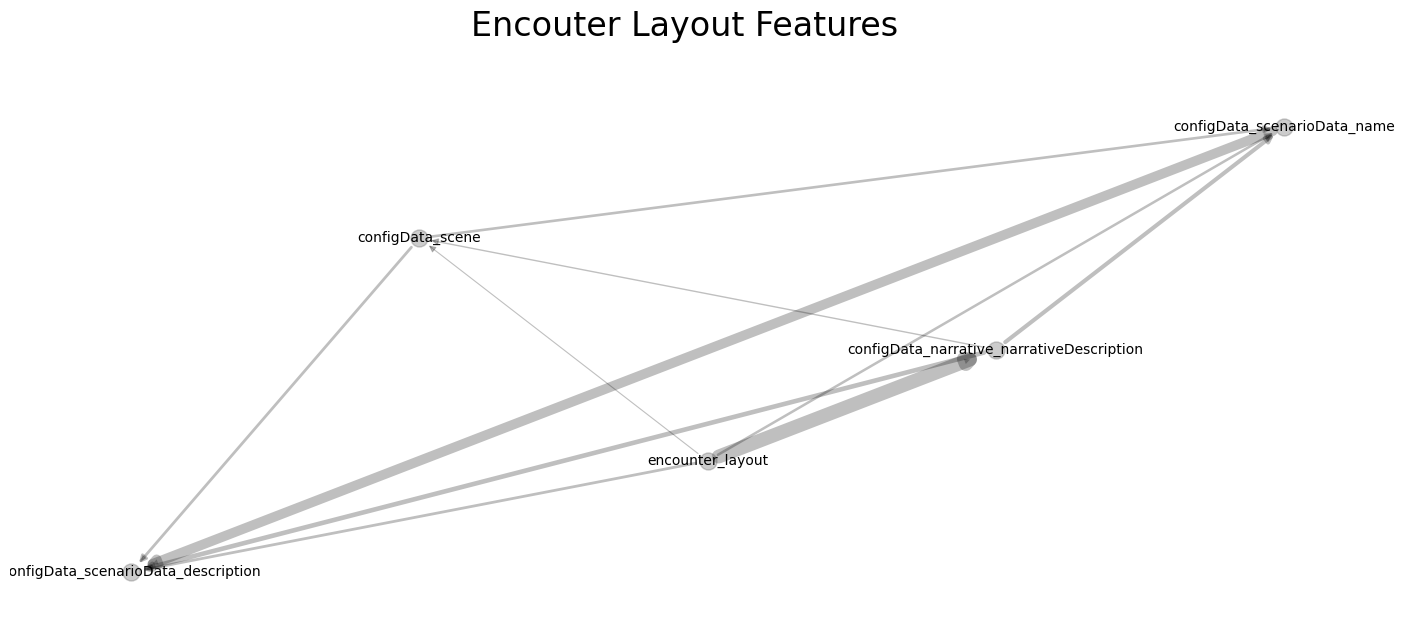

In [73]:

import matplotlib.pyplot as plt
show_subgraph(dg, suptitle='Encouter Layout Features', nodes_list_list=None, node_color=np.array([0.4, 0.4, 0.4, 1.0]), verbose=False)

In [75]:

columns_list = ['configData_scene', 'configData_scenarioData_name', 'configData_scenarioData_description']
display(metrics_evaluation_open_world_file_stats_df[columns_list].drop_duplicates().sort_values(columns_list))
display(metrics_evaluation_open_world_file_stats_df.groupby(columns_list, dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

,configData_scene,configData_scenarioData_name,configData_scenarioData_description
6,sim-desert,Desert,Desert
12,sim-jungle,Jungle Eval,Jungle Eval
0,sim-sub,Submarine Eval,submarine Eval Scenario
3,sim-urban-sanitized,Urban,Urban Scenario
2,NaN,NaN,NaN


,,,record_count
configData_scene,configData_scenarioData_name,configData_scenarioData_description,
sim-desert,Desert,Desert,9
sim-jungle,Jungle Eval,Jungle Eval,13
sim-sub,Submarine Eval,submarine Eval Scenario,13
sim-urban-sanitized,Urban,Urban Scenario,11
NaN,NaN,NaN,14


In [76]:

metrics_evaluation_open_world_file_stats_df.sample(5).T

,11,36,50,1,13
logger_version,1.4,1.4,1.4,1.4,1.4
session_uuid,23081f6e-875e-44f5-8bd0-edc3905f5c2c,8b6c4aed-0983-4a76-99fb-cec08dc26b92,c6d3a90f-68c0-4948-bd96-537e80973605,04f80090-9e61-431d-8473-dccb75fed04d,2e8f6555-a7fa-4b54-8132-c030d697b4ad
file_name,Metrics Evaluation Open World/23081f6e-875e-44...,Metrics Evaluation Open World/8b6c4aed-0983-4a...,Metrics Evaluation Open World/c6d3a90f-68c0-49...,Metrics Evaluation Open World/04f80090-9e61-43...,Metrics Evaluation Open World/2e8f6555-a7fa-4b...
session_file_date,2024-03-14 00:00:00,2024-04-05 00:00:00,2024-03-20 00:00:00,2024-03-14 00:00:00,2024-03-20 00:00:00
session_file_name,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
ST_ConfFC_Omni_Text,4.0,NaN,3.0,4.0,3.0
AD_Del_Text,0.5,NaN,1.0,1.0,1.0
AD_ConfFC_Text,2.5,NaN,2.5,2.5,2.5
AD_Del_Omni_Text,1.0,NaN,0.0,1.0,1.0


In [ ]:

# Get the unique count of each column
for cn in sorted(metrics_evaluation_open_world_file_stats_df.columns): print(cn, metrics_evaluation_open_world_file_stats_df[cn].nunique())

In [ ]:

sorted(metrics_evaluation_open_world_file_stats_df.columns)

In [79]:

display(metrics_evaluation_open_world_file_stats_df.groupby('responder_type').size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))

,record_count
responder_type,


In [4]:

# Show all patient names
old_patient_names_set = set([
    'Adept Shooter Root', 'Adept Victim Root', 'Broken Bob Root', 'Broken Gloria Root', 'Broken Helga Root', 'Civilian 1 Female Root', 'Civilian 1 Root',
    'Civilian 2 Root', 'Intelligence Officer Root', 'Local Civilian with Internal Bleeding Root', 'Local Soldier 1 Root', 'Marine 1 Male Root', 'Marine 2 Male Root',
    'Marine 3 Male Root', 'Marine 4 Male Root', 'Marine with Leg Amputation Root', 'Marine with Narrative Root', 'NPC 1 Root', 'NPC 2 Root', 'NPC 3 Root',
    'NPC 4 Root', 'NPC Root', 'Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root',
    'Navy Solider 4 Female Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root', 'Open World Marine 1 Female Root',
    'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 2 Male Root', 'Open World Marine 3 Male Root',
    'Open World Marine 4 Male Root', 'Patient U Root', 'Patient V Root', 'Patient W Root', 'Patient X Root', 'Simulation Root', 'Tutorial Military Marine Root',
    'US Soldier 1 Root', 'bystander Root', 'electrician Root', 'patient U Root', 'patient V Root', 'patient W Root', 'patient X Root'
])
mask_series = ~logs_df.patient_id.isnull()
all_patient_names = sorted(logs_df[mask_series].patient_id.unique())
old_patient_names_set.symmetric_difference(set(all_patient_names))

{'Broken Bob Root', 'Broken Helga Root', 'Intelligence Officer Root', 'Marine with Leg Amputation Root', 'Local Civilian with Internal Bleeding Root', 'Marine with Narrative Root', 'Navy Solider 4 Female Root', 'Tutorial Military Marine Root', 'Broken Gloria Root'}

In [5]:

# Show all the responder types in the registry
df = data_frames_dict['first_responder_master_registry_file_stats_df']
mask_series = ~df.responder_type.isnull()
sorted(df[mask_series].responder_type.unique())

['EM-FAC', 'EM-RES1', 'EM-RES2', 'EM-RES3', 'EMIM-RES1', 'EMIM-RES3', 'EMS FELO', 'EMT-Basic', 'EMT-I', 'EMT-Intermediate', 'M4-ATEM', 'M4-FM', 'M4-SURGERY', 'M4-SY', 'Nurse', 'Other HP', 'Paramedic', 'TEMS']

In [6]:

# Show if you have any "file" columns in the logs data frame
sorted([cn for cn in logs_df.columns if 'file' in cn])

[]